<a href="https://colab.research.google.com/github/kyunghyuncho/ammi-2019-nlp/blob/master/01-day-LM/ngram_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling

## Goal: compute a probabilty distribution over all possible sentences:


## $$p(W) = p(w_1, w_2, ..., w_T)$$

## This unsupervised learning problem can be framed as a sequence of supervised learning problems:

## $$p(W) = p(w_1) * p(w_2|w_1) * ... * p(w_T|w_1, ..., w_{T-1})$$

## If we have N sentences, each of them with T words / tokens, then we want to max:

## $$log p(W) = \sum_{n = 1}^N \sum_{i=1}^{T} log p(w_i | w_{<i})$$




# N-gram language model

## Goal: estimate the n-gram probabilities using counts of sequences of n consecutive words

## Given a sequence of words $w$, we want to compute

##  $$P(w_i|w_{i−1}, w_{i−2}, …, w_{i−n+1})$$

## Where $w_i$ is the i-th word of the sequence.

## $$P(w_i|w_{i−n+1}, ..., w_{i−2}, w_{i−1}) = \frac{p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w_i)}{\sum_{w \in V} p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w)}$$

## Key Idea: We can estimate the probabilities using counts of n-grams in our dataset 


# Let's see this in Practice

In [192]:
# TODOs
# fix the test file
# make files with 
#: implement the neural LM with concat instead of summation -- so that you have a fixed input etc.
# make a separate
# create some slides with pictures maybe explaining the model visualizations -- line by line
# get google cloud working
# make it work on gpu
# show them kenlm and how to use to do different stuff with it
# use the same sentences to generation and testing etc.
# explain perplexity
# ngram, ff, rnn, rnn+attention
# do sentence generation
# do long sentences
# compare different n-grams -- 2,3,more

### Install if needed

TODO: should we install as needed and import as needed or all at once?

In [193]:
# # run if you dont have it installed
# !pip install more_itertools
# !pip install spacy# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager\
# !python -m spacy download en_core_web_sm

### Imports

In [194]:
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy
import itertools
from operator import itemgetter 
from glob import glob
from tqdm import tqdm_notebook, tqdm
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import string
import re
import more_itertools as mit  # not built-in package
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 

In [195]:
torch.manual_seed(1)


## Data Processing

In [196]:
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 

class AmazonReviewsDataset(TabularDataset):
    
    urls = [
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_CDs_and_Vinyl_5.json.gz',
           'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Health_and_Personal_Care_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Tools_and_Home_Improvement_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Office_Products_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Pet_Supplies_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Automotive_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Grocery_and_Gourmet_Food_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Patio_Lawn_and_Garden_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz',
#             'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz',
        ]
    name='amazonreviews'
    dirname='processed'

In [197]:
# # download_done = AmazonReviewsDataset.download(root='data/', check=True)

# # if above does not work do this in stead in cd ammi-2019-nlp/data
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
# !gunzip reviews_Clothing_Shoes_and_Jewelry_5.json.gz


In [198]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

def tokenize(s):
    return RETOK.findall(s)

text_field = data.Field(sequential=True, tokenize=tokenize, include_lengths=True, use_vocab=True, lower=True, batch_first=True)

In [ ]:
dataset = AmazonReviewsDataset(path='/home/roberta/ammi-2019-nlp/data/reviews_Clothing_Shoes_and_Jewelry_5.json', format='json', fields={'reviewText': ('reviewText', text_field), 'summary': ('summary', text_field)})


In [ ]:
# lets check it
# lets use fstrings btw
print(f'Number of samples : {len(dataset.examples)}')

for ex in dataset.examples:
    print(f'Review: \n {ex.reviewText} \n\n Summary: \n {ex.summary}')
    break

In [ ]:
# convert the dataset to a list of strings
# each string represents a review
all_reviews = []
for ex in dataset.examples:
    all_reviews.append(ex.reviewText)
len(all_reviews)

In [ ]:
all_reviews[0]

In [ ]:

_tqdm = tqdm_notebook  # prolly you need jupyter widget for this, change for tqdm for simple tqdm

NUM_SENTENCES = len(all_reviews)
NUM_SENTENCES_TRAIN = int(0.8*NUM_SENTENCES)
NUM_SENTENCES_TEST = int(0.1*NUM_SENTENCES)
NUM_SENTENCES_VALID = NUM_SENTENCES - NUM_SENTENCES_TRAIN - NUM_SENTENCES_TEST

train_reviews = all_reviews[:NUM_SENTENCES_TRAIN]
test_reviews = all_reviews[NUM_SENTENCES_TRAIN:NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST]
valid_reviews = all_reviews[NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST:NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST+NUM_SENTENCES_VALID]


In [ ]:
type(train_reviews), len(train_reviews), type(train_reviews[0]), type(train_reviews[0][0]), train_reviews[0][11], train_reviews[0]#, test_reviews[0], valid_reviews[0]


In [ ]:
# Create .txt files with the reviews

with open('../data/amazon_reviews_clothing_train.txt', 'w') as f:
    for review in train_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")
        
with open('../data/amazon_reviews_clothing_test.txt', 'w') as f:
    for review in test_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")
        
with open('../data/amazon_reviews_clothing_valid.txt', 'w') as f:
    for review in valid_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")

### Load Data from .txt Files

In [ ]:
# Read data from .txt files and create lists of reviews

train_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_train.txt', 'r') as f:
    reviews = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
for review in reviews:
    train_data.append(review.split())
    
test_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_test.txt', 'r') as f:
    reviews = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
for review in reviews:
    test_data.append(review.split())
    
valid_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_valid.txt', 'r') as f:
    reviews = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
for review in reviews:
    valid_data.append(review.split())

In [ ]:

type(train_data), len(train_data), \
type(train_data[0]), len(train_data[0]), \
type(train_data[0][0])




In [ ]:
train_data[0], train_data[0][0]


### Process the Data

In [188]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')               
punctuations = string.punctuation
# punctuations = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~' 
TAG_RE = re.compile(r'<[^>]+>') # get rid off HTML tags from the data

def remove_tags(text):
    return TAG_RE.sub('', text)

def lower_case(parsed):
    return [token.text.lower() for token in parsed] #and (token.is_stop is False)]

def remove_punc(parsed):
    return [token.text for token in parsed if (token.text not in punctuations)]

def tokenize_dataset(dataset):
   # tokenize each sentence -- each tokenized sentence will be an element in token_dataset
    token_dataset = []
    # tokenize all words -- each token will be an item in all_tokens (in the order given by the list of sentences)
    all_tokens = []     # all the tokens -- 

    for sample in tqdm(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = lower_case(sample)       # make words lower case
#         tokens = remove_punct(tokens)     # remove punctuation
        token_dataset.append(tokens)    
        all_tokens += tokens
        
    return token_dataset, all_tokens

In [189]:
punctuations, punctuations[0], \
type(punctuations), len(punctuations), type(punctuations[0]), 

('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', '!', str, 32, str)

In [190]:
TAG_RE

re.compile(r'<[^>]+>', re.UNICODE)

In [173]:
# TODO: for now only work with small subset of the data -- switch to all data later
train_data = train_data[:80]
test_data = test_data[:10]
valid_data = valid_data[:10]

In [174]:
train_data[0], len(train_data)

(['!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!',
  '!'],
 80)

In [54]:
# Tokenize the Datasets
# TODO: this takes a really long time !! why?
train_data_tokenized, all_tokens_train = tokenize_dataset(train_data)
test_data_tokenized, all_tokens_test = tokenize_dataset(test_data)
valid_data_tokenized, all_tokens_valid = tokenize_dataset(valid_data)


80it [00:00, 84.36it/s]
10it [00:00, 189.38it/s]
10it [00:00, 185.14it/s]


Let's look at the tokenized data!

In [56]:
# Number of All Tokens
len(all_tokens_train), all_tokens_train[:20], len(train_data_tokenized[0]), train_data_tokenized[0]

(59187,
 ['[',
  "'",
  'this',
  "'",
  ',',
  "'",
  'is',
  "'",
  ',',
  "'",
  'a',
  "'",
  ',',
  "'",
  'great',
  "'",
  ',',
  "'",
  'tutu',
  "'"],
 186,
 ['[',
  "'",
  'this',
  "'",
  ',',
  "'",
  'is',
  "'",
  ',',
  "'",
  'a',
  "'",
  ',',
  "'",
  'great',
  "'",
  ',',
  "'",
  'tutu',
  "'",
  ',',
  "'",
  'and',
  "'",
  ',',
  "'",
  'at',
  "'",
  ',',
  "'",
  'a',
  "'",
  ',',
  "'",
  'really',
  "'",
  ',',
  "'",
  'great',
  "'",
  ',',
  "'",
  'price',
  "'",
  ',',
  "'",
  '.',
  "'",
  ',',
  "'",
  'it',
  "'",
  ',',
  "'",
  'doesn',
  "'",
  ',',
  '"',
  "'",
  '"',
  ',',
  "'",
  't',
  "'",
  ',',
  "'",
  'look',
  "'",
  ',',
  "'",
  'cheap',
  "'",
  ',',
  "'",
  'at',
  "'",
  ',',
  "'",
  'all',
  "'",
  ',',
  "'",
  '.',
  "'",
  ',',
  "'",
  'i',
  "'",
  ',',
  '"',
  "'",
  '"',
  ',',
  "'",
  'm',
  "'",
  ',',
  "'",
  'so',
  "'",
  ',',
  "'",
  'glad',
  "'",
  ',',
  "'",
  'i',
  "'",
  ',',
  "'",
  'looked',
  "'",

#### Build the Vocabulary 


In [89]:
# TODO: do we use both train and valid and not test for this??  !! train only top 90%
voc = list(set(all_tokens_train))
print('Word vocabulary size: {} words'.format(len(voc)))             

Word vocabulary size: 14010 words


### CORPUS ANALYSIS (Train + Valid Data)

#### Number of Tokens in the Corpus Data


In [90]:
print("Number of All Tokens ", len(all_tokens_train) + len(all_tokens_valid))

Number of All Tokens  580204


In [91]:
print("Number of All UNIQUE Tokens ", len(voc))

Number of All UNIQUE Tokens  14010


#### Number of Sentences in the Train Data


In [92]:
print("Number of Sentences ", len(train_data_tokenized), len(valid_data_tokenized))

Number of Sentences  8000 1000


#### Count how often each sentence length occurs. Visualize this! 

#### Average sentence length

## N-grams

#### Generate a list of words and their corresponding frequencies. Which are the 10 most frequent words?



### Function for padding the sentences with special markers sentence beginning and end, i.e. $<bos>$ and $<eos>$

In [93]:
def pad_sentences(input_list, n):
    result_list = []
    for l in input_list:
        padded = ["<bos>" for i in range((n - 1))] + l +["<eos>" for i in range((n - 1))]
        result_list.append(padded)
    return result_list

In [94]:
NGRAM = 2  # change this to make different N grams for each token

train_data_padded = pad_sentences(train_data_tokenized, NGRAM)
test_data_padded = pad_sentences(test_data_tokenized, NGRAM)
valid_data_padded = pad_sentences(valid_data_tokenized, NGRAM)


Let's check our padding!

In [95]:
train_data_padded[0]

['<bos>',
 'this',
 'is',
 'a',
 'great',
 'tutu',
 'and',
 'at',
 'a',
 'really',
 'great',
 'price',
 'it',
 'doesn',
 't',
 'look',
 'cheap',
 'at',
 'all',
 'i',
 'm',
 'so',
 'glad',
 'i',
 'looked',
 'on',
 'amazon',
 'and',
 'found',
 'such',
 'an',
 'affordable',
 'tutu',
 'that',
 'isn',
 't',
 'made',
 'poorly',
 'a',
 '\n',
 '<eos>']

### Function for finding all N-grams

In [96]:
def find_ngrams(input_list, n):
    result_list = []
    for l in input_list:
        result_list.append(list(zip(*[l[i:] for i in range(n)])))
    return result_list

#### Convert the dataset to its corresponding n-gram version

In [97]:
NGRAM = 2  # change this to make different N grams for each token

# now make train and valid dicts
train_data_ngram = find_ngrams(train_data_padded, NGRAM)
valid_data_ngram = find_ngrams(valid_data_padded, NGRAM)
test_data_ngram = find_ngrams(test_data_padded, NGRAM)

Let's check our n-grams!

In [98]:
train_data_ngram[0]

[('<bos>', 'this'),
 ('this', 'is'),
 ('is', 'a'),
 ('a', 'great'),
 ('great', 'tutu'),
 ('tutu', 'and'),
 ('and', 'at'),
 ('at', 'a'),
 ('a', 'really'),
 ('really', 'great'),
 ('great', 'price'),
 ('price', 'it'),
 ('it', 'doesn'),
 ('doesn', 't'),
 ('t', 'look'),
 ('look', 'cheap'),
 ('cheap', 'at'),
 ('at', 'all'),
 ('all', 'i'),
 ('i', 'm'),
 ('m', 'so'),
 ('so', 'glad'),
 ('glad', 'i'),
 ('i', 'looked'),
 ('looked', 'on'),
 ('on', 'amazon'),
 ('amazon', 'and'),
 ('and', 'found'),
 ('found', 'such'),
 ('such', 'an'),
 ('an', 'affordable'),
 ('affordable', 'tutu'),
 ('tutu', 'that'),
 ('that', 'isn'),
 ('isn', 't'),
 ('t', 'made'),
 ('made', 'poorly'),
 ('poorly', 'a'),
 ('a', '\n'),
 ('\n', '<eos>')]

#### Generate a complete list of trigrams occurring in the corpus. Which are the 10 most frequent trigrams?



#### Determine count statistics on the trigram frequencies, i.e. compute so-called count-counts (how many trigrams occur once, twice, : : :). Plot their distribution.

### Create N-gram Vocabulary with Corresponding Counts

In [99]:
max_vocab_size = 1000

all_train_tokens = list(mit.flatten(train_data_ngram + valid_data_ngram))
counted_tokens = Counter(all_train_tokens)

vocab, count = zip(*counted_tokens.most_common(max_vocab_size))


In [100]:
# Let's look at some numbers!
len(all_train_tokens), len(vocab), len(count)

(589204, 1000, 1000)

In [101]:
vocab[:2], count[:2]

((('\n', '<eos>'), ('<bos>', 'i')), (9000, 3040))

### Create N-gram Dictionary

In [102]:
# save index 1 for unk, 0 for pad, 1 for bos, 2 for eos
PAD_IDX = 0
UNK_IDX = 1
BOS_IDX = 2
EOS_IDX = 3

id2token = list(vocab)
token2id = dict(zip(vocab, range(4, 4+len(vocab)))) 
id2token = ['<pad>', '<unk>', '<bos>', '<eos>'] + id2token

token2id['<pad>'] = PAD_IDX 
token2id['<unk>'] = UNK_IDX
token2id['<bos>'] = BOS_IDX 
token2id['<eos>'] = EOS_IDX

In [103]:
len(id2token), len(token2id)

(1004, 1004)

Lets check the dictionary by loading random token from it!


In [104]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 645 ; token ('is', 'no')
Token ('is', 'no'); token id 645


#### Generate a list of trigrams in the corpus using only the words in the vocabulary. 

#### Generate count statistics of the trigram frequencies for this modified corpus as well. What do you notice in comparison to the previous exercise?

#### Determine the out-of-vocabulary (OOV) rate, i.e. the percentage of running words in the corpus which are not covered by the vocabulary.

### Functions for Converting from Token to ID and back

In [105]:
def _text2id(doc):
    return [token2id[t] if t in token2id else UNK_IDX for t in doc]

def _id2text(vec):
    return [id2token[i] for i in vec]
    

In [106]:
train_data_id = []
for d in train_data_ngram:
    train_data_id.append(_text2id(d))
    
valid_data_id = []
for d in valid_data_ngram:
    valid_data_id.append(_text2id(d))
    
train_data_id_merged = []
for d in train_data_id:
    train_data_id_merged.append((d, 0))

valid_data_id_merged = []
for d in valid_data_id:
    valid_data_id_merged.append((d, 0))


In [107]:
len(train_data_id), len(train_data_id_merged), train_data_id_merged[0]

(8000,
 8000,
 ([35,
   23,
   17,
   78,
   1,
   1,
   1,
   277,
   1,
   1,
   585,
   1,
   418,
   80,
   956,
   1,
   1,
   154,
   507,
   13,
   1,
   1,
   500,
   1,
   1,
   356,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   258,
   1,
   1,
   1,
   1,
   4],
  0))

In [108]:
# let's look at what we created
train_data_id[0][0], train_data_ngram[0][0], train_data_id_merged[0][0], len(train_data_id_merged), len(train_data_id)

(35,
 ('<bos>', 'this'),
 [35,
  23,
  17,
  78,
  1,
  1,
  1,
  277,
  1,
  1,
  585,
  1,
  418,
  80,
  956,
  1,
  1,
  154,
  507,
  13,
  1,
  1,
  500,
  1,
  1,
  356,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  258,
  1,
  1,
  1,
  1,
  4],
 8000,
 8000)

In Part 1 you generated a trigram frequency list for a given vocabulary.
Determine the list of bigram frequencies from it by summing over the first word position:
N(v;w) = N(; v;w) =
X
u
N(u; v;w)
Analogously, recompute the frequencies of unigrams.
Now, extract bigrams/unigrams directly from the corpus using your implementation from part 1
and compare it to the recomputed versions. What do you notice? How could you x this problem
without changing the recomputation method?

### Function for Getting N-gram counts for already tokenized data

In [109]:
def ngram_counts(data, n):
    print("data item ", data[0], "\n")
    data_pad = pad_sentences(data, n)
    print("padded item ", data_pad[0], "\n")
    ngram_data = find_ngrams(data_pad, n)
    print("ngram item ", ngram_data[0], "\n")
    all_train_tokens = list(mit.flatten(ngram_data))
    counted_tokens = Counter(all_train_tokens)
    vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
    print("vocab item ", vocab[0], "\n")
    print("count item ", count[0], "\n")
    return vocab, count

### Function for Getting N-gram Dict

In [110]:
def ngram_dict(data, n):
    data_pad = pad_sentences(data, n)
    ngram_data = find_ngrams(data_pad, n)
    
    all_train_tokens = list(mit.flatten(ngram_data))
    counted_tokens = Counter(all_train_tokens)
    vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
    
    # save index 1 for unk, 0 for pad, 1 for bos, 2 for eos
    PAD_IDX = 0
    UNK_IDX = 1
    BOS_IDX = 2
    EOS_IDX = 3

    id2token = list(vocab)
    token2id = dict(zip(vocab, range(4, 4+len(vocab)))) 
    id2token = ['<pad>', '<unk>', '<bos>', '<eos>'] + id2token

    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    token2id['<bos>'] = BOS_IDX 
    token2id['<eos>'] = EOS_IDX
    
    data_ids = []
    for d in ngram_data:
        data_ids.extend(_text2id(d))

    return id2token, token2id, data_ids, vocab, count

### Unigram Counts

In [111]:
train_data_tokenized[0]

['this',
 'is',
 'a',
 'great',
 'tutu',
 'and',
 'at',
 'a',
 'really',
 'great',
 'price',
 'it',
 'doesn',
 't',
 'look',
 'cheap',
 'at',
 'all',
 'i',
 'm',
 'so',
 'glad',
 'i',
 'looked',
 'on',
 'amazon',
 'and',
 'found',
 'such',
 'an',
 'affordable',
 'tutu',
 'that',
 'isn',
 't',
 'made',
 'poorly',
 'a',
 '\n']

In [112]:
vocab_unigrams, count_unigrams = ngram_counts(train_data_tokenized, 1)
vocab_unigrams[:2], count_unigrams[:2]

data item  ['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', 'it', 'doesn', 't', 'look', 'cheap', 'at', 'all', 'i', 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', 't', 'made', 'poorly', 'a', '\n'] 

padded item  ['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', 'it', 'doesn', 't', 'look', 'cheap', 'at', 'all', 'i', 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', 't', 'made', 'poorly', 'a', '\n'] 

ngram item  [('this',), ('is',), ('a',), ('great',), ('tutu',), ('and',), ('at',), ('a',), ('really',), ('great',), ('price',), ('it',), ('doesn',), ('t',), ('look',), ('cheap',), ('at',), ('all',), ('i',), ('m',), ('so',), ('glad',), ('i',), ('looked',), ('on',), ('amazon',), ('and',), ('found',), ('such',), ('an',), ('affordable',), ('tutu',), ('that',), ('isn',), ('t',), ('made',), ('poor

((('the',), ('i',)), (21933, 20896))

### Bigram Counts

In [113]:
vocab_bigrams, count_bigrams = ngram_counts(train_data_tokenized, 2)
vocab_bigrams[:2], count_bigrams[:2]

data item  ['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', 'it', 'doesn', 't', 'look', 'cheap', 'at', 'all', 'i', 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', 't', 'made', 'poorly', 'a', '\n'] 

padded item  ['<bos>', 'this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', 'it', 'doesn', 't', 'look', 'cheap', 'at', 'all', 'i', 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', 't', 'made', 'poorly', 'a', '\n', '<eos>'] 

ngram item  [('<bos>', 'this'), ('this', 'is'), ('is', 'a'), ('a', 'great'), ('great', 'tutu'), ('tutu', 'and'), ('and', 'at'), ('at', 'a'), ('a', 'really'), ('really', 'great'), ('great', 'price'), ('price', 'it'), ('it', 'doesn'), ('doesn', 't'), ('t', 'look'), ('look', 'cheap'), ('cheap', 'at'), ('at', 'all'), ('all', 'i'), ('i', 'm'), ('m', 'so'), ('so', 'glad'), ('glad

((('\n', '<eos>'), ('<bos>', 'i')), (8000, 2693))

### Trigram Counts

In [114]:
vocab_trigrams, count_trigrams = ngram_counts(train_data_tokenized, 3)
vocab_trigrams[:2], count_trigrams[:2]

data item  ['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', 'it', 'doesn', 't', 'look', 'cheap', 'at', 'all', 'i', 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', 't', 'made', 'poorly', 'a', '\n'] 

padded item  ['<bos>', '<bos>', 'this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', 'it', 'doesn', 't', 'look', 'cheap', 'at', 'all', 'i', 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', 't', 'made', 'poorly', 'a', '\n', '<eos>', '<eos>'] 

ngram item  [('<bos>', '<bos>', 'this'), ('<bos>', 'this', 'is'), ('this', 'is', 'a'), ('is', 'a', 'great'), ('a', 'great', 'tutu'), ('great', 'tutu', 'and'), ('tutu', 'and', 'at'), ('and', 'at', 'a'), ('at', 'a', 'really'), ('a', 'really', 'great'), ('really', 'great', 'price'), ('great', 'price', 'it'), ('price', 'it', 'doesn'), ('it', 'doesn', 't'), ('d

((('\n', '<eos>', '<eos>'), ('<bos>', '<bos>', 'i')), (8000, 2693))

#### Determine the list of bigram frequencies from it by summing over the first word position:

#### $ N(u, v, w) = \sum_u N(\cdot, v, w) $

#### Do the same for the unigrams. Do we get the same numbers as before?

## N-gram Probabilities

## $$P(w|w_{−n}, ..., w_{−2}, w_{−1}) \approx \frac{c(w_{−n}, ..., w_{−2}, w_{−1}, w)}{\sum_{w \in V} c(w_{−n}, ..., w_{−2}, w_{−1}, w)}$$


## Bigram Probabilities

## $$p(w_i | w_{i-1}) = \frac{c(w_{i-1}, w_i)}{\sum_{w_i} c(w_{i-1}, w_i)} $$


## Bigram LM
##  $$p(s) = \prod_{i = 1} ^ {N + 1} p(w_i | w_{i-1})$$

### Function for computing the probability of an n-gram

In [115]:
def get_count_ngram(data, token, n):
    id2token, token2id, data_ids, vocab, count = ngram_dict(data, n)
    if token in token2id:
        return np.sum([i == token_id for i in data])
    else:
        return 0

In [116]:
def get_prob_ngram(data, token, n):
    count = get_count_ngram(data, token, n)
    all_counts = 0
    for t in vocab:
        all_counts += get_count_ngram(data, t, n)
    if all_counts > 0:
        return count / all_counts
    else:
        return 0

### Function for computing the probability of a sentence

In [117]:
def get_prob_sentence(vocab, count, n):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-117-26cfecd6b523>, line 2)

### Example
### Bigram LM: $$ p(i \; love \; this \; light) = p(i|\cdot) \; p(love|i)\;  p(this|love)\;  p(light|this) \\
\approx \frac{c(i, \cdot)}{\sum_w c(\cdot, \; w)} \; \frac{c(love, i)}{\sum_wc(i, \; w)}\;  \frac{c(this, love)}{\sum_wc(love, \;w)}\;  \frac{c(light, this)}{\sum_wc(this, \;w)}$$ 

### Trigram LM: $$ p(i \; love \; this  \;light) = p(i|\cdot, \cdot) \; p(love|\cdot, i) \; p(this|i, love)\;  p(light|love, this)$$ 



### Another Example -- where this approach usually fails

### Bigram LM: $$ p(john \; went \; to \; the \; moon) = p(john|\cdot) p(went|john) p(to|went) p(the|to) p(moon|the)$$ 

### Trigram LM: $$ pp(john \; went \; to \; the \; moon = p(john|\cdot, \cdot) p(went|\cdot, john) p(to|john, went) p(the|went, to) p(moon|to, the)$$ 



## Smoothing -- which ones to show? comparisons?

### Why do we need smoothing for n-gram language modeling?

## Add-One Smoothing

## Additive Smoothing

## Smoothing: Linear Interpolation with Absolute Discounting

## Bigram Probabilities

### $$p_{bi} = max \large{ \frac{N(v, w) - b_{bi}}{N(v), 0}  + b_{bi} \frac{V - N_0(v, \cdot)}{N(v)} p_{uni(w)} \large}$$

### $$p_{uni} = max \large{ \frac{N(w) - b_{uni}}{N, 0}  + b_{uni} \frac{V - N_0(\cdot)}{N} \frac{1}{V}}$$

### $$b_{bi} = \frac{N_1(\cdot, \cdot)}{N_1(\cdot, \cdot) + 2*N_2(\cdot, \cdot)}$$

### $$b_{uni} = \frac{N_1(\cdot)}{N_1(\cdot) + 2*N_2(\cdot)}$$


### $$N_r(\cdot) = \sum_{w: N(w) = r} 1$$

### $$N_r(\cdot, \cdot) = \sum_{v, w: N(v, w) = r} 1$$

### $$N_r(v, \cdot) = \sum_{w: N(v, w) = r} 1$$

### V is the number of words in the vocabulary

### $N_r(\cdot, \cdot)$ and $N_r(\cdot)$  are the count-counts for bigrams and unigrams respectively $


In [118]:
# TODO: Let's compute the bigram frequencies / probabilities



### Let's check that the probabilities sum up to one
### $$\sum_w p_{bi}(w|v) = \sum_w p_{uni}(w) = 1$$



In [119]:
# TODO: compute the sums

# show rank for each word in a sentence
# explain perplexity 

#### Let's look at some examples and see if they make sense

### Perplexity

### $PP = exp(-\frac{LL}{\sum_k(N_k + 1)})$

### $LL = \sum_{k=1}^{K} \sum_{n=1}^{N_k + 1} log p_{bi}(w_{k,n} | w_{k,n-1})$

### Sentece Probability

### Sentence Generation

# Neural Language Modeling

## Make a PyTorch Dataset out of our set of dicts

In [120]:
class ImdbDataset(Dataset):
    def __init__(self, data_list, max_inp_length=None, device='cpu'):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        self.data = data_list
        self.max_len = max_inp_length
        self.data_tensors = []
        for (i, t) in tqdm_notebook(self.data):
            self.data_tensors.append((torch.LongTensor(i[:self.max_len]), torch.LongTensor([t])))
            #TODO: fix error regarding to(device)
#             self.data_tensors.append((torch.LongTensor(i[:self.max_len]).to(device), torch.LongTensor([t]).to(device)))
              
    def __getitem__(self, key):
        (inp, tgt) = self.data_tensors[key]
        
        return inp, tgt, len(inp)

    def __len__(self):
        return len(self.data)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor
    
def batchify(batch):
    maxlen = max(batch, key = itemgetter(2))[-1]
    batch_list = []
    target_list = []
    for b in batch:
        batch_list.append(pad(b[0], maxlen, dim=0, pad=PAD_IDX))
        target_list.append(b[1])
    input_batch = torch.stack(batch_list, 0)
    target_batch = torch.stack(target_list, 0)
    
    return input_batch, target_batch

In [121]:
train_dataset = ImdbDataset(train_data_id_merged, max_inp_length=None, device='cuda')
train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

valid_dataset = ImdbDataset(valid_data_id_merged, max_inp_length=None, device='cuda')
valid_loader = DataLoader(valid_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

## Model

In [122]:
class BagOfNGrams(nn.Module):
    def init_layers(self):
        for l in self.layers:
            if getattr(l, 'weight', None) is not None:
                torch.nn.init.xavier_uniform_(l.weight)
    
    def __init__(self, vocab_size, emb_dim=300, hidden_size=512, reduce='sum', nlayers=2, act='ReLU', nclasses=2, dropout=0.1, batch_norm=False):
        super(BagOfNGrams, self).__init__()
        self.emb_dim = emb_dim
        self.reduce = reduce
        self.nlayers = nlayers
        self.hidden_size = hidden_size
        self.nclasses = nclasses
        self.act = getattr(nn, act)
        self.embedding = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=emb_dim, mode=reduce)
        if batch_norm is True:
            self.batch_norm = nn.BatchNorm1d(self.emb_dim)
        self.layers = nn.ModuleList([nn.Linear(self.emb_dim, self.hidden_size)])
        self.layers.append(self.act())
#         self.layers.append(nn.Dropout(p=dropout))
        for i in range(self.nlayers-2):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(self.act())
            self.layers.append(nn.Dropout(p=dropout))
        self.layers.append(nn.Linear(self.hidden_size, 1))
        self.init_layers()
    
    def forward(self, x):
        postemb = self.embedding(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(postemb)
        else:
            x = postemb
        for l in self.layers:
            x = l(x)
        
        return x

model = BagOfNGrams(len(id2token), emb_dim=30, hidden_size=2048, act='Tanh', nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)
model.cuda()

AttributeError: module 'torch.nn.init' has no attribute 'xavier_uniform_'

## Loss and Optimizer


In [123]:
learning_rate = 0.1
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, nesterov=True)
#optimizer = torch.optim.Adagrad(params=model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NameError: name 'model' is not defined

## Testing 

In [124]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, labels in loader:
        outputs = torch.sigmoid(model(data))
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

## Training

In [125]:
# TODO fix cuda issue!!! 
train_losses = []
num_epochs=20
for epoch in range(num_epochs):
    for i, (data, labels) in tqdm(enumerate(train_loader)): 
        data.cpu()
        labels.cpu()
        model.cpu()
        
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.view(-1), labels.float().view(-1))
        loss.backward()
        print(loss.item())
        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 1 == 0 and epoch > 0:
        val_acc = test_model(loader=valid_loader, model=model)
        print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))

0it [00:00, ?it/s]


NameError: name 'model' is not defined

#### Visualize the Loss 

/home/roberta/miniconda3/lib/python3.6/site-packages/altair/utils/core.py:90: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  "Defaulting to nominal.".format(typ))


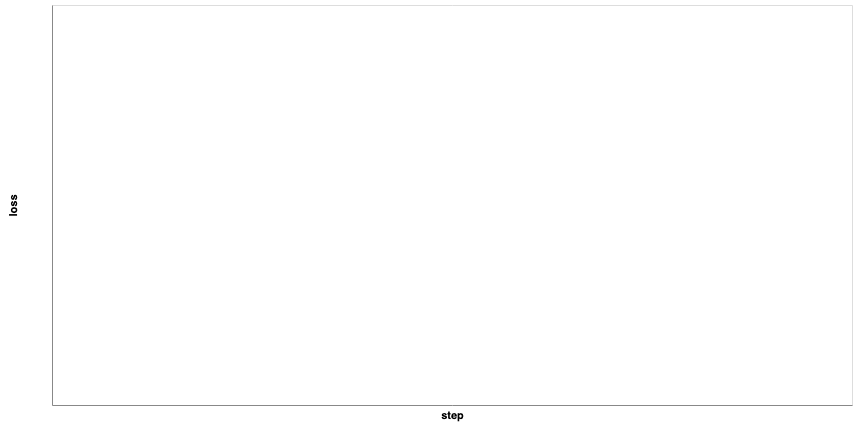

In [126]:
#!pip install altair
import altair as alt
import pandas

batch_loss = []
for i,l in enumerate(train_losses):
    batch_loss.append((i,l))

df = pandas.DataFrame(batch_loss, columns=['step', 'loss'])

alt.Chart(df).mark_line().encode(
    alt.X('step', scale=alt.Scale()),
    alt.Y('loss', scale=alt.Scale(type='log'))).properties(
        width=800,
        height=400
    )

## Analysis & Examples

## Compare N-gram LM to Neural LM

## Using FastText

## Using KenLM

In [16]:
out = vocab.FastText(language='en')

.vector_cache/wiki.en.vec:  19%|█▉        | 1.25G/6.60G [11:49<50:35, 1.76MB/s]


KeyboardInterrupt: 

In [ ]:
text_field.build_vocab(dataset, max_size=30000, vectors=out)

In [ ]:
# making a batch iterator
train_loader = data.BucketIterator(dataset=dataset, batch_size=4, sort_key=lambda x: len(x.reviewText), device=torch.device('cpu'), sort_within_batch=True, repeat=False)

In [ ]:
batch = next(iter(train_loader))
print(batch)

In [ ]:
def _vec2txt(vec):
    return [text_field.vocab.itos[t] for t in vec]

In [ ]:
print(batch.reviewText[0][0])
print(_vec2txt(batch.reviewText[0][0]))